Modelo de clasificación de imágenes con Data Augmentation
=========================================================

## Introducción

La clasificación de objetos es la tarea por la cual un modelo de aprendizaje automático asigna una o varias etiquetas a diferentes imágenes dependiendo del contenido de la misma. Esta tarea se volvió muy popular en 2012 en el contexto de aprendizaje automático ya que fué la primera tarea en alcanzar una performance sustancialmente mayor que con técnicas clásicas. 

Desde aquel entonces, el progreso en este campo ha sido tan grande que hoy en día disponemos de modelos de aprendizaje automático con performance superiores a las de un humano. Un ejemplo clásico es el de clasificación de razas de perror donde los modelos alcanzan a distinguir razas que resultan imposibles distinguir para incluso personas altamente experimentadas en esto.

### Preparación del ambiente

Intalamos las librerias necesarias

In [1]:
!wget https://raw.githubusercontent.com/santiagxf/M72109/master/docs/vision/tasks/classification/cnn_class.txt \
    --quiet --no-clobber
!pip install -r cnn_class.txt --quiet

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'cnn_class.txt'


### Sobre el conjunto de datos de este ejemplo

Para ejemplificar esta técnica utilizaremos un conjunto de datos muy popular llamado CIFAR-10. CIFAR-10 es un conjunto de datos que consiste en 60.000 imagenes a color de 32x32 agrupadas en 10 clases, con 6000 imagenes cada una. Hay alrededor de 50000 imagenes para entrenamiento y 10000 para testing.

Las categorias son:
 - airplane
 - automobile
 - bird
 - cat
 - deer
 - dog
 - frog
 - horse
 - ship
 - truck

Podemos cargar este conjunto de datos facilmente utilizando `tensorflow-datasets`:

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds

ds, info = tfds.load('cifar10', split='train', shuffle_files=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteJLWKB1/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteJLWKB1/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [3]:
print("Numero de clases: ", info.features["label"].num_classes)
print("Clases disponibles: ", info.features["label"].names)

Numero de clases:  10
Clases disponibles:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Veamos algunos ejemplos:

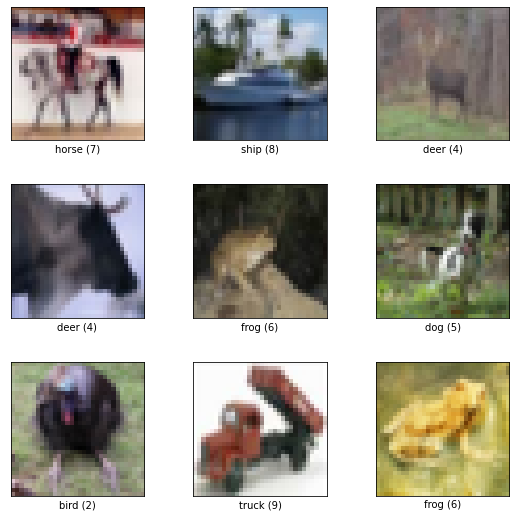

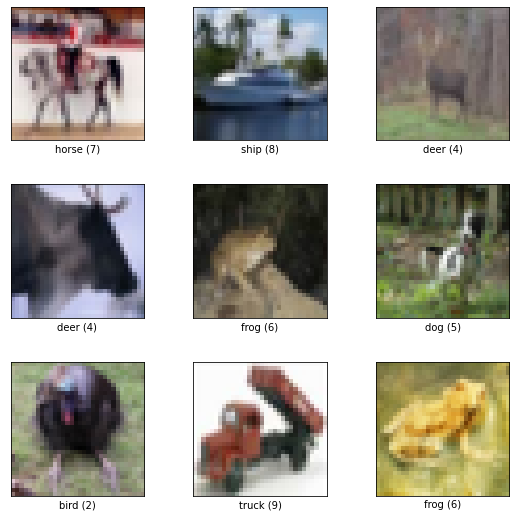

In [4]:
tfds.show_examples(ds, info)

## Construcción de una red neuronal convolucional

Antes de comenzar necesitaremos verificar que tenemos el runtime correcto en nuestro ambiente. Esta tarea se beneficiará mucho de una GPU.

In [5]:
import tensorflow as tf
print("GPUs disponibles: ", len(tf.config.experimental.list_physical_devices('GPU')))

GPUs disponibles:  1


### Entendiendo una estructura basada en CNN estandar

En este primer intento de solución del problema, generaremos una red basada en CNNs típica. En este caso la misma constará de:
 - 2 capas de CNN
 - 1 capas de Pooling
 - 1 capa de regularización
 - Una red de 2 capas fully-connected

In [6]:
def buildModel():
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
    model.add(keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    
    return model

Instanciamos nuestro modelo y verificamos su arquitectura

In [7]:
model = buildModel()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                524352    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                6

Antes de comenzar el entrenamiento, configuraremos nuestro conjunto de datos para una tarea supervisada. Esto lo hacemos especificando el parametro *as_supervised=True* lo cual nos da la posibilidad de acceder a las anotaciones del conjunto de datos.

In [8]:
(training_set, validation_set) = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)

Configuramos los parametros de entrenamiento:

In [9]:
BATCH_SIZE=64
EPOCHS = 3

training_set_batch = training_set.batch(batch_size=BATCH_SIZE).cache().repeat()
validation_set_batch = validation_set.batch(batch_size=BATCH_SIZE).cache().repeat()
train_size = info.splits['train'].num_examples
test_size = info.splits['test'].num_examples

Comenzamos el entrenamiento

In [10]:
history = model.fit(training_set_batch, 
                    epochs=EPOCHS,
                    steps_per_epoch=train_size,
                    validation_data=validation_set_batch,
                    validation_steps=test_size)

Epoch 1/3
50000/50000 [==============================] - 507s 10ms/step - loss: 0.6684 - accuracy: 0.7716 - val_loss: 1.2468 - val_accuracy: 0.6616
Epoch 2/3
50000/50000 [==============================] - 463s 9ms/step - loss: 0.3743 - accuracy: 0.8786 - val_loss: 1.3201 - val_accuracy: 0.6591
Epoch 3/3
50000/50000 [==============================] - 465s 9ms/step - loss: 0.3305 - accuracy: 0.8969 - val_loss: 1.4154 - val_accuracy: 0.6689


> Dado que estamos utilizando un objeto de tipo `tf.Dataset` como argumento de `validation_data` de `Model.fit`, Keras no sabe por cuantos etapas hay que validar. Por este motivo el argumento `validation_steps` fue configurado.

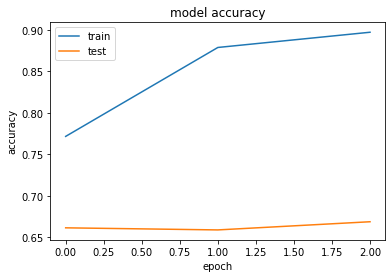

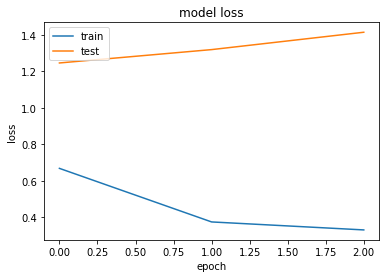

In [13]:
import matplotlib.pyplot as plt

def plot_history(history):
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

plot_history(history)

### Apilando estructuras de CNN

Verifiquemos los resultados si repetimos la estructura básica de la red para generar características de mayor nivel. En este segundo intento de solución del problema, generaremos una red basada en CNNs de 3 bloques concatenados. En este caso la misma constará de:
 - 3 bloques de:
   - 2 capas de CNN
   - 1 capas de Pooling
 - 1 capa de regularización
 - Una red de 2 capas fully-connected

In [14]:
def buildModel():
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
    model.add(keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    
    return model

Instanciamos nuestro modelo y verificamos su arquitectura

In [15]:
model = buildModel()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 128)        

Comenzamos el entrenamiento

In [16]:
history = model.fit(training_set_batch, 
                    epochs=EPOCHS,
                    steps_per_epoch=train_size,
                    validation_data=validation_set_batch,
                    validation_steps=test_size)

Epoch 1/3
50000/50000 [==============================] - 950s 19ms/step - loss: 0.4996 - accuracy: 0.8294 - val_loss: 0.9502 - val_accuracy: 0.7566
Epoch 2/3
50000/50000 [==============================] - 939s 19ms/step - loss: 0.3650 - accuracy: 0.8892 - val_loss: 1.0295 - val_accuracy: 0.7693
Epoch 3/3
50000/50000 [==============================] - 947s 19ms/step - loss: 0.3559 - accuracy: 0.9006 - val_loss: 1.2571 - val_accuracy: 0.7666


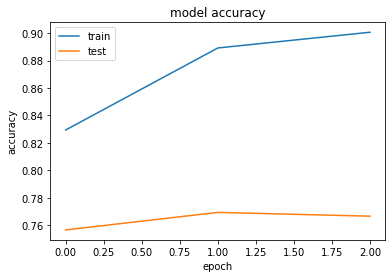

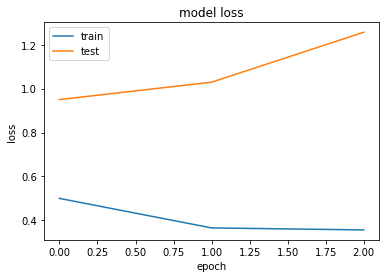

In [17]:
plot_history(history)